<a href="https://colab.research.google.com/github/stijndecuyper/Tripadvisor_ML_Project/blob/main/ML_Sprint3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machinaal leren: groep 12 - Sprint 3



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
import pandas as pd
import seaborn as sn
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import string
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from imgaug import augmenters as iaa

from keras.optimizers import SGD
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import glob
import os
from PIL import Image
import cv2
from keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dropout
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.preprocessing import OneHotEncoder
import pickle
import gc
import random
import tensorflow as tf

# Getting data

In [ ]:
restaurant_df = pd.read_csv("/content/drive/MyDrive/MachineLearning/restaurant_listings.csv")
review_df = pd.read_csv("/content/drive/MyDrive/MachineLearning/reviews.csv")
restaurant_coor_df = pd.read_csv("/content/drive/MyDrive/MachineLearning/adressen.csv")
joined_df = pd.read_csv("/content/drive/MyDrive/MachineLearning/joined_images_df.csv")

# Possible tasks:

- Predict the price of a restaurant, based on the distance to the closest parking. (Gent only)
    - Gent has a lot of open datasets. We searched for datasets that included factors that are important for us, when searching for a restaurant. We choose for Parking.

- Improve the clustering model of sprint2.

- Predict the cuisines based on the images.

- AI that draws images of the restaurant.

- Detect anbormalities in the images.


# Task 1: Predicting cuisines based on images

## Task 1.1 Loading images for new deep learning

---

Because we are using deep learning, we can include more information. Therefore we don't need to use the HOG-values from sprint 2 anymore.

We'll use the RGB values of the images and label them with the cuisine of the restaurant.

At first, we'll only use the first cuisine of the restaurant. Later we'll try to use multi-label classification where the same image has multiple cuisines.



### Task 1.1.1 Setting up the labels.
---

Right now, we're using the first cuisine of the list for the restaurants, disregarding the others. </br>
For further clean-up we've dropped the rows where the cuisine was NaN.

For the machine, it's easier to understand numbers then text, so we've replaced the text with numerical values.

First we would use a labelencoder, but the model could misunderstand the data. To prevent this we used a one-hot-encoder.

In [ ]:
path_images = glob.glob("/content/drive/MyDrive/MachineLearning/images/*.jpg")

afbeeldingen_df = pd.DataFrame(path_images, columns=["path"])
afbeeldingen_df["bestandsnaam"] = afbeeldingen_df["path"].apply(os.path.basename)
afbeeldingen_df["restaurant_id"] = afbeeldingen_df["bestandsnaam"].str.split("_",expand=True)[0]
afbeeldingen_df['restaurant_id'] = afbeeldingen_df['restaurant_id'].astype(int)

afbeeldingen_df = pd.merge(afbeeldingen_df, restaurant_df, left_on="restaurant_id", right_on="id", how="inner")

afbeeldingen_df['cuisines'] = afbeeldingen_df['cuisines'].str.split(',').str[:1]
afbeeldingen_df['cuisines'] = afbeeldingen_df['cuisines'].str[0]

afbeeldingen_df.dropna(subset=['cuisines'], inplace=True)
afbeeldingen_df.reset_index(inplace=True)

enc = OneHotEncoder(handle_unknown='ignore')
y = afbeeldingen_df['cuisines'].values
y = enc.fit_transform(y.reshape(-1,1))
y_df = pd.DataFrame(y.toarray())

data_hot = y_df
data_hot['path'] = afbeeldingen_df['path']
data_hot

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,path
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/MachineLearning/images/...
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/MachineLearning/images/...
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/MachineLearning/images/...
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/MachineLearning/images/...
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/MachineLearning/images/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/MachineLearning/images/...
5550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/MachineLearning/images/...
5551,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/MachineLearning/images/...
5552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/MachineLearning/images/...


The table now contains the path to the image and the rest of the columns are the hot_encoded values.

### Task 1.1.2 Setting up images
---

Because the images have different sizes, we'll resize them all to (224,224,3).

  -> Images will have height and width 224.

  -> The 3rd dimension with size 3 is for the RGB-values.

In sprint 2, we saw that a lot of images where black. These images aren't useful for the classification, so we opted to remove them. Also, images containing only a single color were removed.
- We did this by using the grayscale of the image and calculating the amount of zeros.


In [ ]:
images_df = []
label_df = []

# Iterate over the rows of the dataframe
for index, row in data_hot.iterrows():
  # Make sure the 'path' column exists and is not empty
  if 'path' in row and row['path']:
    # Try to read the image and process it
    try:
      img = cv2.imread(row['path'])
      gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      if cv2.countNonZero(gray_image) != 0 and cv2.countNonZero(gray_image) != gray_image.size:
        # Remove all one color images
        img = cv2.resize(img, (224, 224))
        if img.shape[2] == 1:
          img = np.dstack([img, img, img])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)/255.0
        images_df.append(img)
        label_df.append(row.iloc[:49])
    except Exception as e:
      # Print the error message if there is an error reading the image
      print(f"Error reading image at index {index}: {e}")
  else:
    # Print a message if the 'path' column is missing or empty
    print(f"Missing or empty 'path' column at index {index}")

### Task 1.1.2.1 Deleting duplicate images

When detecting abnormals in the data. (Task 2) we saw that there were a lot of duplicate images. (stock pictures?).

The same images had different labels, that leads to the model having to deal with contradictions, making the training noticeably harder.

In [ ]:
# Remove duplicate images from the dataframe
df = pd.DataFrame()
df['image'] = images_df
df['label'] = label_df

# Create a function to check if an image is a duplicate
def is_duplicate(row):
    image = row['image']
    # Check if the image is a duplicate
    return any(np.all(image == x) for x in df['image'].values[:row.name])

# Use the apply method to apply the function to each row of the dataframe
df['duplicate'] = df.apply(is_duplicate, axis=1)

# Remove duplicate images from the dataframe
df = df.drop(df[df['duplicate'] == True].index)

images_df = df['image'].values.tolist()
label_df = pd.DataFrame(df['label'].to_list())

## Task 1.2 Preparing the neural network

### Task 1.2.1 Calculate the amount of output classes

For classification, the last layer of the neural network needs the same amount of outputs as there are possiblie classes. Herefor, we calculate all possible classes. These are all the unique cuisines in the dataset.

In [ ]:
amountOfClasses = afbeeldingen_df['cuisines'].unique().size
amountOfClasses

49

### Task 1.2.2 Split the data in test and training

Because we have a small amount of data, we take a bigger part of it for training. 90% for training and 10% for testing.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images_df, label_df, test_size=0.1) # 90% training and 10% test

#y_train = to_categorical(y_train, amountOfClasses)
#y_test = to_categorical(y_test, amountOfClasses)

### Task 1.2.3 Setting up the CNN Image Classification model
---

We want to do image classification, to achieve this goal we'll use a convolutional neural network.

The model will be a linear stack of layers.

- We start with a convolutional layer with 32 filters and a kernel size of 3 by 3.
The input shape are the images.
This layer is responsible for extracting features from the input image.
We start with a lower filter size for the first convolutional layer and increase the size as we go deeper into the network. In a Convolutional Neural Network, the filters in the deeper layers are able to capture more complex features of an image because they are able to combine the features learned by the filters in the earlier layers. When you increase the number of filters in the deeper layers, it allows the network to learn more complex and higher-level features of the image, which can be more useful for image classification tasks.

- We add an activation layer to it. We use ReLU as the activation function, with the purpose of introducing non-linearity into the model. ReLU is a common choice as activation function, as it is efficient and could allow the model to converge faster opposed to some other activation functions.

- Next we want to downsample the output of the convolution layer. The pool size of (2,2) is used to downsample the input by a factor of 2 in both dimensions, which reduces the spatial dimensions of the output and allows the network to focus on the most important features.

- We repeat this pattern, an increase of filters (32 to 64)  will increase the number of parameters in the model, which can allow the model to learn more complex features of the input data. At each pattern we added a dropout, to prevent overfitting. By randomly setting a fraction of the activations in the model to zero during training. the model is forced to learn more from the remaining parameters.

- In the end we flatten the output, so our 3D feature map results in 1D feature vectors.

- For the output we use 2 connected dense layers, where the last dense has the same amount of output nodes as there are labels/classes.

- For the last activation-layer was use softmax, a common used activation layer for a cCassification Neural Network. Softmax converts the output of the final layer of the network, which is a set of raw prediction scores, into a probability distribution over the classes. This makes it possible for the network to distribute the probabilities of the different classes.

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3,3), input_shape=(224,224,3))) #Eerste layer,
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten()) # Converting 3D feature maps to 1D feature vectors

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(amountOfClasses)) #Amount of outputs
model.add(Activation('softmax')) #For multi classification

### Task 1.2.4 Compile the model
---

#### Learning rate and momentum
The model will start with a learning rate of 0.01 and momentum of 0.7.

-> When stuck in a local minimum, we increased the momentum, by 0.1.

-> Over time we increased the learning rate, for faster modeling and testing if there are some improvements.


We start with a higher momentum, to get to the global minima faster and attemting to escape local minima.

We do however take the risk of going past the global minima by using a higher momentum.


For the learning rate we use a small value, so that the optimizer takes small steps when updating the model's weights. The network will train slower, but also more accurately to the global minimum.

#### Lossfunction and optimizer

For the loss function we choose the most common one, within Tensorflow for multi-classification: categorical_crossentropy.

For the optimizer we started with using SGD, because:
  - It's easy to use/implement
  - It only needs to compute the gradient of the loss function, but not for the whole dataset, but for a single or small batch of datapoints.
  - SGD is capable of dealing with high-dimensional datasets, which is useful when working with images.
  - SGD should be better at escaping local minima.

In [ ]:
# compile model
opt = SGD(lr=0.05, momentum=1)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


## Task 1.3 Fitting model

We increased the batch_size for better results. The downsite to this, is that it will take more time for the neural network to train.

A smaller batch size can lead to faster training, but can also result in higher variance in the model's performance. To prevent the higher variance, we started with a higher amount of samples to use.

We used the most common batch size: 32,64 and 128. Starting with 32 and increasing to 128.

The number of epochs starts at 100 and will be increased to see if there are better results. The model with go over the dataset 100 times.
-  that means: (6094/32) * 100 batches during the training.
  - Depending on the batch size, the amount of batches will be less.

In [ ]:
batch_size = 32 #Number of samples before updating the network
nb_epochs = 10 #Epoch = aantal keer dat het algoritme over de training dataset gaat.

#model.fit(x=np.array(X_train),
#          y=np.array(y_train, dtype=np.float))
#X_train = tf.convert_to_tensor(X_train)

model.fit(x=np.array(X_train),
          y=np.array(y_train, dtype=np.float),
          batch_size=batch_size,
          epochs=nb_epochs)

<ipython-input-53-80a9b062cf29>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y=np.array(y_train, dtype=np.float),


Epoch 1/10
95/95 [==============================] - 15s 58ms/step - loss: 6.4557 - accuracy: 0.3193
Epoch 2/10
95/95 [==============================] - 5s 53ms/step - loss: 3.1138 - accuracy: 0.3513
Epoch 3/10
95/95 [==============================] - 5s 54ms/step - loss: 3.1201 - accuracy: 0.3865
Epoch 4/10
95/95 [==============================] - 5s 54ms/step - loss: 3.0791 - accuracy: 0.2642
Epoch 5/10
95/95 [==============================] - 5s 54ms/step - loss: 3.1854 - accuracy: 0.3928
Epoch 6/10
95/95 [==============================] - 5s 54ms/step - loss: 3.2183 - accuracy: 0.3846
Epoch 7/10
95/95 [==============================] - 5s 54ms/step - loss: 3.0694 - accuracy: 0.3582
Epoch 8/10
95/95 [==============================] - 5s 54ms/step - loss: 3.3566 - accuracy: 0.3503
Epoch 9/10
95/95 [==============================] - 5s 54ms/step - loss: 3.3325 - accuracy: 0.3727
Epoch 10/10
95/95 [==============================] - 5s 54ms/step - loss: 3.3278 - accuracy: 0.4037


In [ ]:
loss, acc = model.evaluate(np.array(X_test), np.array(y_test, dtype=np.float), batch_size=batch_size)
print('Loss:', loss, 'accuracy: ', acc)

<ipython-input-54-792df1b3fd92>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  loss, acc = model.evaluate(np.array(X_test), np.array(y_test, dtype=np.float), batch_size=batch_size)


11/11 [==============================] - 1s 43ms/step - loss: 3.2365 - accuracy: 0.4837
Loss: 3.2364821434020996 accuracy:  0.48367953300476074


## Task 1.4 Evaluate model:

In the model above, we can assume that the model is stuck in a local minimum.

We tried to train with different the learning rates and momentums, but without success. Even by playing with the batches and the amount of epochs, we couldn't increase the performance of the model.

That the test-data had a higher score then the trainingsdata, could indicate that the distribution of the data isn't suited for this task.

## Task 1.5 Improve the results

It is quite evident that our validation accuracy is not that good. There are a number of tricks that we can use to improve the performance of the model.

- Adding more layers to the model. This can help the model learn more complex features from the input data, allowing it to make more accurate predictions.

- A larger dataset can provide the model with more examples to learn from, which can help it generalize better to unseen data.
  
  -> (-) We don't have more data.

- Using data augmentation: This can help the model generalize better to unseen data by providing it with more diverse examples to learn from.
  - Check the distribution of the data. Increase the amount of datapoints, which are less present in the dataset. This seems a promising and achievable solution for our problem.
  
- Use a different optimizer. Using a different optimizer, such as Adam or RMSprop, can potentially improve the model's performance.

## Task 1.6 Discuss distribution of the data

=> In the dataset the duplicates are already removed. </br>
</br>

We see that the data has unbalanced classes. This can lead to problems such as:
- High chance that our test-data wouldn't representive for the trainingdata.

A large amount of rows are labeled as 'Belgian', this label occurs 5x more frequently than the value with the second highest frequency.
  - We need to fix the unbalanced classes before we can train the model.


Options for unbalanced data:
  - Under-sampling: here, samples of the majority class will be removed. Because of the lack of data, this isn't hulpful for us.

  - Over-sampling: here samples of the minority class will be duplicated
  - Data augmenation: inserting new samples based on existing samples. But they are slightly different.
    - This will affect the balance of the dataset.
  - Instead of taking the first cuisine, we can pick a random cuisines correlated to the restaurant.

<br/>

=> We opted for **data augmentation**

Reasons for the unbalanced data (by gut feeling) :
  - We take the first cuisine that is listed in the datarow. Further in the notebook we'll try multi-label classification, where we won't have this problem.
  - The dataset is for Belgian restaurants, so it isn't the weird that the majority of the cuisines are labeled as 'Belgian'.

In [ ]:
categories_decoded = enc.inverse_transform(label_df)
categories_decoded

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:582: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, accept_sparse="csr")


array([['Belgian'],
       ['Belgian'],
       ['Belgian'],
       ...,
       ['Steakhouse'],
       ['Steakhouse'],
       ['Steakhouse']], dtype=object)

In [ ]:
df = pd.DataFrame(categories_decoded, columns=['values'])
counts = df['values'].value_counts()

counts

Belgian             1517
Italian              508
French               391
European             188
Bar                  187
Chinese              153
Cafe                 112
Japanese             108
International         93
Pizza                 87
American              81
Turkish               78
Spanish               64
Contemporary          63
Seafood               49
Sushi                 48
Pub                   47
Asian                 45
Dutch                 44
Thai                  43
Mediterranean         42
Grill                 40
Fast Food             40
Mexican               38
Moroccan              29
Indian                28
Healthy               26
Greek                 21
Brazilian             19
Barbecue              19
Steakhouse            16
Lebanese              15
African               13
Brew Pub              12
Persian                8
Diner                  7
Deli                   7
Gastropub              7
Middle Eastern         6
Irish                  6


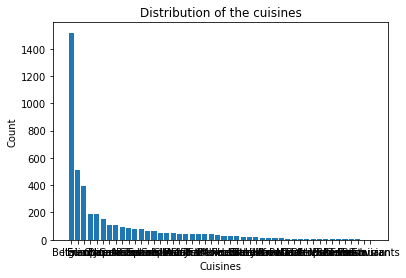

'Belgian'

In [ ]:
plt.bar(counts.index, counts.values)
plt.xlabel('Cuisines')
plt.ylabel('Count')
plt.title('Distribution of the cuisines')
plt.show()

counts.index[0]

### Task 1.6.1 Fixing the unbalanced cuisines.
---

Option 1: data augmentation
-> but we only need to do data augmentation for specific classes.


Option 2: Oversampling: duplicate the data from the unbalanced part. </br>
-> Would this result in a dataset accurately representing reality? </br>
-> Rare cuisines with 1 image could get easily overfitted </br>


Option 3: Remove the cuisines with 'Belgian' only when this is the only label given.


option 4: Undersampling
  - Here, we'll balance the class distribution of the cuisines by reducing the size of the over-represented class 'Belgian'.


</br>
=> In the beginning we went for the first option, because it also helps with the lack of data. But it uses to much RAM, so the notebook keeps crashing. Herefor we wrote our own data augmentation script, instead of the built-in libraries.
</br>

Later we combined the augmented data with option 4.
Here we used **RandomUnderSampler** for undersampling the data.

#### Task 1.6.1.1 Data augmentation

Every randomized attribute has a 50% chance of being used over the image.
This makes it possible that some images are just duplicated, but that's fine.

We'll ignore the images that are labed 'Belgian', because we have enough of those. We need more samples of the other cuisines.

First we tried using the built-in library.

In [ ]:
label_df[0][6] #Labeled as Belgian

1.0

#### Task 1.6.1.2 Own version of data augmentation

Google collab keeps crashing and can't handle the process for data augmentation. </br>

As a result we aren't using the built-in data augmentation libraries, because these keep crashing and are asking for too much ram. We wrote our own version for data augmentation.

```python
  if random.randint(0,9) < 5:
    flipped_img = cv2.flip(img, 1) #Flip it horizontal
    images_df.append(flipped_img)
    label_df.append(row.iloc[:49])
```

In [ ]:
images_df = []
label_df = []

# Iterate over the rows of the dataframe
for index, row in data_hot.iterrows():
  # Make sure the 'path' column exists and is not empty
  if 'path' in row and row['path']:
    # Try to read the image and process it
    try:
      img = cv2.imread(row['path'])
      gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      if cv2.countNonZero(gray_image) != 0 and cv2.countNonZero(gray_image) != gray_image.size:
        # Remove all one color images
        img = cv2.resize(img, (224, 224))
        if img.shape[2] == 1:
          img = np.dstack([img, img, img])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)/255.0

        if row[6] != 1.0: #Filter belgian
            if random.randint(0,9) < 5:
              flipped_img = cv2.flip(img, 1) #Flip it horizontal
              images_df.append(flipped_img)
              label_df.append(row.iloc[:49])

        images_df.append(img)
        label_df.append(row.iloc[:49])
    except Exception as e:
      # Print the error message if there is an error reading the image
      print(f"Error reading image at index {index}: {e}")
  else:
    # Print a message if the 'path' column is missing or empty
    print(f"Missing or empty 'path' column at index {index}")

Removing duplicate images

In [ ]:
# Remove duplicate images from the dataframe
df = pd.DataFrame()
df['image'] = images_df
df['label'] = label_df

# Create a function to check if an image is a duplicate
def is_duplicate(row):
    image = row['image']
    # Check if the image is a duplicate
    return any(np.all(image == x) for x in df['image'].values[:row.name])

# Use the apply method to apply the function to each row of the dataframe
df['duplicate'] = df.apply(is_duplicate, axis=1)

# Remove duplicate images from the dataframe
df = df.drop(df[df['duplicate'] == True].index)

images_df = df['image'].values.tolist()
label_df = pd.DataFrame(df['label'].to_list())

#### Task 1.6.1.3 Check new distribution

The dataset is still unbalanced, we can fix this by applying some undersampling on rows labeled as 'Belgian'.

(–) The new dataset should be a good representive of the original dataset.</br> We need to be keep this in mind when we are training the model with this dataset. </br>
(–) First we do some augmentation for adding more samples and now we are reducing the amount of samples. </br> That's not ideal, but because the rows aren't related to each other, it shouldn't harm the data that much.

In [ ]:
categories_decoded = enc.inverse_transform(label_df)
#categories_decoded

df = pd.DataFrame(categories_decoded, columns=['values'])
counts = df['values'].value_counts()

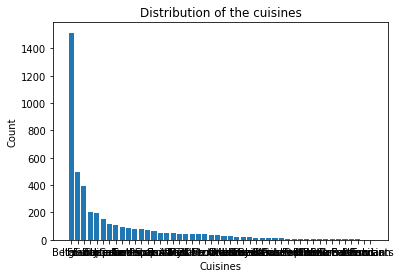

'Belgian'

In [ ]:
plt.bar(counts.index, counts.values)
plt.xlabel('Cuisines')
plt.ylabel('Count')
plt.title('Distribution of the cuisines')
plt.show()

counts.index[0]

#### Task 1.6.1.4 Undersampling the data.

The data is still unbalanced, we are going to undersample the label 'Belgian'. </br> For this, we'll use RandomUnderSampler. </br>

RandomUnderSampler is easy to implement and is straightforward.

It randomly selects a subset of the majority class samples to remove from the dataset, until the class balance is restored.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Flatten the images into a single feature vector
features = np.array(images_df, dtype=np.int)
features = features.reshape(features.shape[0], -1)

labels = np.array(label_df, dtype=np.float)

# Create a RandomUnderSampler object
rus = RandomUnderSampler()

# Use the fit_resample method to undersample the dataset
X_resampled, y_resampled = rus.fit_resample(features, labels)

<ipython-input-7-cbbc50c6bc98>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  features = np.array(images_df, dtype=np.int)
<ipython-input-7-cbbc50c6bc98>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array

In [ ]:
X_resampled = X_resampled.reshape(X_resampled.shape[0], 224, 224, 3)
y_resampled = pd.DataFrame(y_resampled)
y_resampled[48] = 0

In [ ]:
print("Shape images: ")
X_resampled.shape

Shape labels: 


(48, 224, 224, 3)

In [ ]:
print("Shape labels: ")
y_resampled.shape

Shape images: 


(48, 49)

#### Disappointed

The undersampling is too extreme. We have a condensation that's too big. As a result, the training dataset might be too small to train the model.

#### Task 1.6.1.5 Check new distribution

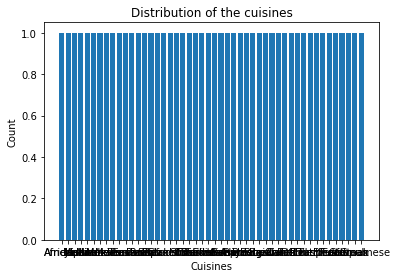

'African'

In [ ]:
categories_decoded = enc.inverse_transform(y_resampled)
#categories_decoded

df = pd.DataFrame(categories_decoded, columns=['values'])
counts = df['values'].value_counts()

plt.bar(counts.index, counts.values)
plt.xlabel('Cuisines')
plt.ylabel('Count')
plt.title('Distribution of the cuisines')
plt.show()

counts.index[0]

##### Task 1.6.1.6 Check amount of datapoints

The distribution of the different cuisines is now balanced. But the amount of datapoints is very low and not useful for training the model. </br>

Taking the previous into consideration, we decided to not fit this data in the model. We'll only test the augmentated data.

### Task 1.6.2 Fitting network with augmentated data

We'll use the last model and fit it again.

The batch_size will be smaller, because the amount of data is way smaller.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images_df, label_df, test_size=0.1) # 90% training and 10% test

In [ ]:
batch_size = 32 #Number of samples before updating the network
nb_epochs = 10 #Epoch = aantal keer dat het algoritme over de training dataset gaat.

model.fit(x=np.array(X_train),
          y=np.array(y_train, dtype=np.float),
          batch_size=batch_size,
          epochs=nb_epochs)

<ipython-input-13-8e2f9d4d4b7e>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y=np.array(y_train, dtype=np.float),


Epoch 1/10
121/121 [==============================] - 16s 56ms/step - loss: 3.1959 - accuracy: 0.2913
Epoch 2/10
121/121 [==============================] - 7s 54ms/step - loss: 6.7583 - accuracy: 0.1914
Epoch 3/10
121/121 [==============================] - 6s 54ms/step - loss: 446.6925 - accuracy: 0.1632
Epoch 4/10
121/121 [==============================] - 7s 54ms/step - loss: 8.1652 - accuracy: 0.1743
Epoch 5/10
121/121 [==============================] - 7s 54ms/step - loss: 7.6021 - accuracy: 0.2381
Epoch 6/10
121/121 [==============================] - 7s 57ms/step - loss: 9.0674 - accuracy: 0.2135
Epoch 7/10
121/121 [==============================] - 6s 54ms/step - loss: 9.3937 - accuracy: 0.2288
Epoch 8/10
121/121 [==============================] - 7s 54ms/step - loss: 7.5302 - accuracy: 0.2067
Epoch 9/10
121/121 [==============================] - 6s 54ms/step - loss: 8.0634 - accuracy: 0.1831
Epoch 10/10
121/121 [==============================] - 6s 53ms/step - loss: 9.3148 - acc

In [ ]:
loss, acc = model.evaluate(np.array(X_test), np.array(y_test, dtype=np.float), batch_size=batch_size)
print('Loss:', loss, 'accuracy: ', acc)

<ipython-input-14-792df1b3fd92>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  loss, acc = model.evaluate(np.array(X_test), np.array(y_test, dtype=np.float), batch_size=batch_size)


14/14 [==============================] - 1s 37ms/step - loss: 9.2154 - accuracy: 0.1072
Loss: 9.215397834777832 accuracy:  0.10722610354423523


### Task 1.6.3 Evaluate model with augmentated data

There isn't a big improvement in the performance of the model. The influence of the distribution didn't have a big impact on the performance. </br> The data itself may be not useful for the given task.

- Other reasons for the even worse results is the used data-augmentation. We could have choose a data augmentation technique that suided better for our data.

- Because we used data-augemntation on the underbalanced data, the model could have learned incorrect patterns.

We could work with a different approach to the dataset. By not taking the first cuisines for each image, but a random cuisine that was assigned to the image. </br> Here, the performance of the model would depend on the training dataset.
If you want to compare different models, the dataset will also be different.

-> Another possibility would be to readjust the neural network, because of the deadlines we didn't go that road.

## Task 1.7 Try the model with a different optimizer

This will be trained with the original dataset. (Not the augmentated dataset)

In [ ]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

batch_size = 32 #In hoeveel gaan we de data splitten.
nb_epochs = 10 #Epoch = aantal keer dat het algoritme over de training dataset gaat, voor dat de parameters aan gepast worden.

model.fit(x=np.array(X_train),
          y=np.array(y_train, dtype=np.float),
          batch_size=batch_size,
          epochs=nb_epochs)

<ipython-input-11-5f9eda4e90b1>:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y=np.array(y_train, dtype=np.float),


Epoch 1/10
95/95 [==============================] - 257s 3s/step - loss: 3.0708 - accuracy: 0.4413
Epoch 2/10
95/95 [==============================] - 250s 3s/step - loss: 2.4788 - accuracy: 0.4449
Epoch 3/10
95/95 [==============================] - 250s 3s/step - loss: 2.4399 - accuracy: 0.4449
Epoch 4/10
95/95 [==============================] - 259s 3s/step - loss: 2.4157 - accuracy: 0.4443
Epoch 5/10
95/95 [==============================] - 254s 3s/step - loss: 2.3769 - accuracy: 0.4443
Epoch 6/10
95/95 [==============================] - 250s 3s/step - loss: 2.2907 - accuracy: 0.4515
Epoch 7/10
95/95 [==============================] - 251s 3s/step - loss: 2.1383 - accuracy: 0.4634
Epoch 8/10
95/95 [==============================] - 251s 3s/step - loss: 1.9263 - accuracy: 0.4944
Epoch 9/10
95/95 [==============================] - 250s 3s/step - loss: 1.7147 - accuracy: 0.5317
Epoch 10/10
95/95 [==============================] - 251s 3s/step - loss: 1.4434 - accuracy: 0.5894


In [ ]:
loss, acc = model.evaluate(np.array(X_test), np.array(y_test, dtype=np.float), batch_size=4)
print('Loss:', loss, 'accuracy: ', acc)

<ipython-input-12-98045edec227>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  loss, acc = model.evaluate(np.array(X_test), np.array(y_test, dtype=np.float), batch_size=4)


85/85 [==============================] - 8s 93ms/step - loss: 2.9825 - accuracy: 0.3086
Loss: 2.982518196105957 accuracy:  0.3086053431034088


The trainingsdata scores better, I think with a bigger amount of trainingsdata, this model would score and train better, without the use of data-augmentation.

But the distribution of the data still has a big impact on the performance of the model.

Tweaking the model more and trying different loss functions and optimizers would be an improvement for the model. </br> Nevertheless, this takes a lot of time, for getting these parameters right.

## Task 1.8 Multi-lable classification for cuisines

For the multi-label classification, we use the same dataset, but with a different preprocessing. We don't use the first cuisine, but we include all the cuisines related to the restaurant. </br>

For every image, we add a new row for each cuisine.

```python
afbeeldingen_Option3_df = afbeeldingen_Option3_df.explode('cuisines').reset_index(drop=True)
```

Later we use one-hot encoding over the cuisines.</br>
Thanks to one-hot encoding, we can combine the different cuisines by grouping by image.

In [ ]:
path_images = glob.glob("/content/drive/MyDrive/MachineLearning/images/*.jpg")

afbeeldingen_Option3_df = pd.DataFrame(path_images, columns=["path"])
afbeeldingen_Option3_df["bestandsnaam"] = afbeeldingen_Option3_df["path"].apply(os.path.basename)
afbeeldingen_Option3_df["restaurant_id"] = afbeeldingen_Option3_df["bestandsnaam"].str.split("_",expand=True)[0]
afbeeldingen_Option3_df['restaurant_id'] = afbeeldingen_Option3_df['restaurant_id'].astype(int)

afbeeldingen_Option3_df = pd.merge(afbeeldingen_Option3_df, restaurant_df, left_on="restaurant_id", right_on="id", how="inner")

afbeeldingen_Option3_df['cuisines'] = afbeeldingen_Option3_df['cuisines'].str.split(',')
afbeeldingen_Option3_df = afbeeldingen_Option3_df.explode('cuisines').reset_index(drop=True)

afbeeldingen_Option3_df.dropna(subset=['cuisines'], inplace=True)
afbeeldingen_Option3_df.reset_index(inplace=True)

enc = OneHotEncoder(handle_unknown='ignore')
y = afbeeldingen_Option3_df['cuisines'].values
y = enc.fit_transform(y.reshape(-1,1))
y_df = pd.DataFrame(y.toarray())

data_hot_multi = y_df
data_hot_multi['path'] = afbeeldingen_Option3_df['path']
data_hot_multi

data_hot_multi = data_hot_multi.groupby("path").sum().reset_index()
data_hot_multi

,path,0,1,2,3,4,5,6,7,8,...,110,111,112,113,114,115,116,117,118,119
0,/content/drive/MyDrive/MachineLearning/images/...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,/content/drive/MyDrive/MachineLearning/images/...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,/content/drive/MyDrive/MachineLearning/images/...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,/content/drive/MyDrive/MachineLearning/images/...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,/content/drive/MyDrive/MachineLearning/images/...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5549,/content/drive/MyDrive/MachineLearning/images/...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5550,/content/drive/MyDrive/MachineLearning/images/...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5551,/content/drive/MyDrive/MachineLearning/images/...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5552,/content/drive/MyDrive/MachineLearning/images/...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Task 1.8.1 Setting up the images

Same as in Task 1.1.2. We filter the images that are black.

In [ ]:
images_df = []
label_df = []

for index, row in data_hot_multi.iterrows():
#for img in path_images:
  try:
    #imgV2 = img
    img = cv2.imread(str(row['path']))

    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if cv2.countNonZero(gray_image) != 0 and cv2.countNonZero(gray_image) != gray_image.size:

      img = cv2.resize(img, (224, 224))
      if img.shape[2] == 1:
          img = np.dstack([img, img, img])

      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = img.astype(np.float32)/255.0
      images_df.append(img)
      label_df.append(row.iloc[-120:])

  except:
    print("Error: ", index)

In [ ]:
# Remove duplicate images from the dataframe
df = pd.DataFrame()
df['image'] = images_df
df['label'] = label_df

# Create a function to check if an image is a duplicate
def is_duplicate(row):
    image = row['image']
    # Check if the image is a duplicate
    return any(np.all(image == x) for x in df['image'].values[:row.name])

# Use the apply method to apply the function to each row of the dataframe
df['duplicate'] = df.apply(is_duplicate, axis=1)

# Remove duplicate images from the dataframe
df = df.drop(df[df['duplicate'] == True].index)

images_df = df['image'].values.tolist()
label_df = pd.DataFrame(df['label'].to_list())

### Task 1.8.2 Preparation of the neural network

#### Task 1.8.2.1 Calculate the amount of outputs classes.

In [ ]:
amountOfClasses = afbeeldingen_Option3_df['cuisines'].unique().size
amountOfClasses

120

#### Task 1.8.2.2 Splitting in test and trainingsdata

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images_df, label_df, test_size=0.1) # 90% training and 10% test

#### Task 1.8.2.3 Setting up the model


It's the same neural network as for multi-classification. The only difference is in the last layer, where we use sigmoid as activation function.

We use the sigmoid activation function, because it's commonly used in the output layer of a neural network for multi-label classification. This is because the sigmoid function maps any input value to a value between 0 and 1, which can be interpreted as a probability.

In [ ]:
np.array(X_train).shape

(3032, 224, 224, 3)

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3,3), input_shape=(224,224,3))) #Eerste layer,
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten()) # Converting 3D feature maps to 1D feature vectors

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(amountOfClasses)) #Amount of outputs
model.add(Activation('sigmoid')) #For multi-label classification

#### Task 1.8.2.4 Compile the model

In [ ]:
# compile model
#opt = SGD(lr=0.05, momentum=1)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Task 1.8.2.5 Fit the model

In [ ]:
batch_size = 32 #Number of samples before updating the network
nb_epochs = 10 #Epoch = aantal keer dat het algoritme over de training dataset gaat.

model.fit(x=np.array(X_train),
          y=np.array(y_train, dtype=np.float),
          batch_size=batch_size,
          epochs=nb_epochs)

<ipython-input-20-8e2f9d4d4b7e>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y=np.array(y_train, dtype=np.float),


Epoch 1/10
95/95 [==============================] - 249s 3s/step - loss: 0.1775 - accuracy: 0.2302
Epoch 2/10
95/95 [==============================] - 244s 3s/step - loss: 0.0732 - accuracy: 0.3384
Epoch 3/10
95/95 [==============================] - 238s 3s/step - loss: 0.0723 - accuracy: 0.3407
Epoch 4/10
95/95 [==============================] - 242s 3s/step - loss: 0.0713 - accuracy: 0.3351
Epoch 5/10
95/95 [==============================] - 244s 3s/step - loss: 0.0711 - accuracy: 0.3371
Epoch 6/10
95/95 [==============================] - 237s 2s/step - loss: 0.0705 - accuracy: 0.3232
Epoch 7/10
95/95 [==============================] - 246s 3s/step - loss: 0.0697 - accuracy: 0.3054
Epoch 8/10
95/95 [==============================] - 251s 3s/step - loss: 0.0685 - accuracy: 0.3229
Epoch 9/10
95/95 [==============================] - 258s 3s/step - loss: 0.0671 - accuracy: 0.3150
Epoch 10/10
95/95 [==============================] - 257s 3s/step - loss: 0.0654 - accuracy: 0.3008


In [ ]:
loss, acc = model.evaluate(np.array(X_test), np.array(y_test, dtype=np.float), batch_size=4)
print('Loss:', loss, 'accuracy: ', acc)

<ipython-input-21-98045edec227>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  loss, acc = model.evaluate(np.array(X_test), np.array(y_test, dtype=np.float), batch_size=4)


85/85 [==============================] - 9s 101ms/step - loss: 0.0973 - accuracy: 0.3056
Loss: 0.09730713069438934 accuracy:  0.30563798546791077


### Task 1.8.2.6 Evaluate multi-label classification

The amount of classes was way bigger then in the multi-classification (120 cuisines vs. 50 cuisines), so the task is harder. We can't make a fair comparison between the 2 models.

Overall, the results of the multi-label classification were okay. Knowing that the model was trained with a small dataset. Multi-label classification is a more difficult task to perform.

The model was also trained for a more realistic task, where a meal could belong to different cuisines, instead of just one.

## Task 1.9 Evaluate different approaches for predicting the cuisines based on the pictue

| Description | Pros | contras |
|----------|----------|----------|
| Classification without data augmentation   | (+) Easy to understand, was a good start. | (-) By the way of selecting the data a lot of cuisines where missing, 50 against 120. <br /> (-) We were stuck in a local minima, but it seems more likely that data wasn't right for the task. <br /> (-) We hadn't have mutch data available, that could be a reason for the underperformance of the neural network. <br /> (-) Data is not in balance, what results in not a good trainingset.|
| Classification with data augmentation   | (+) More available datapoints, should have result in better performance <br /> (+) Data is more in balance, more trainingsdata to train with. | (-) Data augmentation is realy heavy to proces. <br /> (-) Still not working with all the cuisines. <br />|
| Classification with data augmentation + undersampling  | (+) Less 'Belgian' label in the data. <br /> (+) Data is more in balance. | (-) Not the best representation of the data <br /> (-) Still not working with all the cuisines. <br /> (-) really small amount of trainingsdata.|
| Multi-lable classification | (+) All the cuisines are included. <br /> (+) More features <br /> (+) More realistic approche, that a restaurant has multiple cuisines. | (-) Heavy for the computer to process. </br>|


The biggest influence on the performance was when we removed the duplicates. </br>
Here, the amount of contradictions was way lower, therefore the model performed better.

### Task 1.9.1 Overall conclution

Overall I think that the used data wasn't the right data to use for this task.
  - We also needed to clean up a lot of the images, removing duplicates and blank images. This resulted in better performance.
</br> What first seemed like a local minimum, could possible be a global minimum.

  - It would be a good approche to use the results of Task2, for filtering the images.